# Data Gathering, Cleaning, and Exploration

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from census import Census
from scipy import stats

# Census API Key and config
#from config import api_key
from config import api_key
c = Census(api_key, year=2018)

# Dictionary of state abbreviations
from us_state_abbrev import us_state_abbrev

## Census Data

In [2]:
# Make API calls
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E"), {'for': 'county:*'})
# CHECK FOR YEAR (2018?)

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering/Renaming
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "NAME": "Name", "county": "County"})




In [3]:
census = census_pd[["County", "Name", "Population", "Median Age", "Household Income", ]].copy()
census

,County,Name,Population,Median Age,Household Income
0,173,"Sedgwick County, Kansas",512064.0,35.2,54974.0
1,157,"Republic County, Kansas",4686.0,51.1,48022.0
2,065,"Graham County, Kansas",2545.0,51.9,40769.0
3,045,"Douglas County, Kansas",119319.0,29.5,55832.0
4,179,"Sheridan County, Kansas",2506.0,44.3,56071.0
...,...,...,...,...,...
3215,003,"Adams County, Idaho",4019.0,54.2,45319.0
3216,053,"Jerome County, Idaho",23431.0,32.7,49306.0
3217,061,"Lewis County, Idaho",3845.0,48.3,41326.0
3218,073,"Owyhee County, Idaho",11455.0,38.4,40430.0


In [4]:
# Final DataFrame

# Copy and save to csv
census = census_pd[["County", "Name", "Population", "Median Age", "Household Income"]].copy()
census.to_csv("resources/census_data.csv", encoding="utf-8", index=False)

# Combine county name with state for later merging
census['county'] = census['Name'].str.replace(' County', '').str.replace(' Parish', '')
census.drop(['County', 'Name'], axis=1, inplace=True)
census.set_index('county', inplace=True)
census

,Population,Median Age,Household Income
county,,,
"Sedgwick, Kansas",512064.0,35.2,54974.0
"Republic, Kansas",4686.0,51.1,48022.0
"Graham, Kansas",2545.0,51.9,40769.0
"Douglas, Kansas",119319.0,29.5,55832.0
"Sheridan, Kansas",2506.0,44.3,56071.0
...,...,...,...
"Adams, Idaho",4019.0,54.2,45319.0
"Jerome, Idaho",23431.0,32.7,49306.0
"Lewis, Idaho",3845.0,48.3,41326.0


In [5]:
# Summary stats
census.describe()

,Population,Median Age,Household Income
count,3.220000e+03,3220.000000,3219.000000
mean,1.013323e+05,41.277516,50791.797763
std,3.260964e+05,5.356761,14455.719850
min,7.500000e+01,21.700000,12812.000000
25%,1.121425e+04,38.100000,41904.000000
50%,2.595050e+04,41.200000,49514.000000
75%,6.655225e+04,44.300000,57348.000000
max,1.009805e+07,67.000000,136268.000000


## Covid Data

In [6]:
# Read from csv and combine county and state into one column, then drop unnecessary columns 
covid = pd.read_csv('resources/covid-statistics.csv')
covid['county'] = covid['county'] + ', ' + covid['state']
covid.drop(['state', 'fips', 'date'], axis=1, inplace=True)
covid

,county,cases,deaths
0,"Snohomish, Washington",1,0.0
1,"Snohomish, Washington",1,0.0
2,"Snohomish, Washington",1,0.0
3,"Cook, Illinois",1,0.0
4,"Snohomish, Washington",1,0.0
...,...,...,...
2161172,"Sweetwater, Wyoming",10133,115.0
2161173,"Teton, Wyoming",9272,15.0
2161174,"Uinta, Wyoming",5273,34.0
2161175,"Washakie, Wyoming",2150,41.0


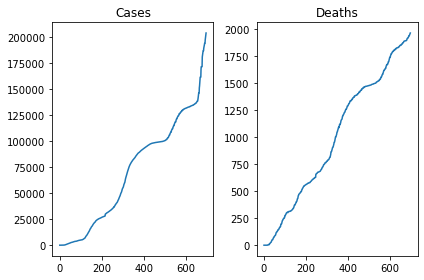

In [7]:
# Visualizing time dependency of cases and deaths for a particular county
fulton = covid[covid['county'] == 'Fulton, Georgia']
xs = range(len(fulton))

plt.subplot(1, 2, 1)
plt.plot(xs, fulton.cases)
plt.title('Cases')

plt.subplot(1, 2, 2)
plt.plot(xs, fulton.deaths)
plt.title('Deaths')

plt.tight_layout()
plt.show()

In [8]:
# Extracting final cumulative cases and deaths per county
covid_total = covid.groupby('county').max()
covid_total.dropna(inplace=True)
covid_total

,cases,deaths
county,,
"Abbeville, South Carolina",6104,57.0
"Acadia, Louisiana",14951,269.0
"Accomack, Virginia",6569,90.0
"Ada, Idaho",103141,915.0
"Adair, Iowa",1488,46.0
...,...,...
"Yuma, Arizona",57792,1046.0
"Yuma, Colorado",1703,22.0
"Zapata, Texas",2889,47.0


In [9]:
# Summary stats
covid_total.describe()

,cases,deaths
count,3.199000e+03,3199.000000
mean,2.321600e+04,280.190685
std,8.613328e+04,1106.320576
min,0.000000e+00,0.000000
25%,2.319500e+03,34.500000
50%,5.803000e+03,84.000000
75%,1.524650e+04,203.000000
max,2.611089e+06,38162.000000


## General Health Data

In [10]:
# Defining function for cleaning up data from chronicdata.cdc.gov
def makehealthcsv(x, colname, boolean_whether_you_want_latitude):
    
    # Filter
    x = x[(x['Stratification1'] == 'Overall') &  (x['Stratification2'] == 'Overall')]
    
    # Use state abbreviation dictionary and create county name column to be consistent with other dataframes
    x = x[x["LocationAbbr"].isin(us_state_abbrev)]
    x['county'] = x['LocationDesc'] + ', ' + x['LocationAbbr'].apply(lambda x: us_state_abbrev[x])
    x['county'] = x['county'].str.replace(' County', '').str.replace(' Parish', '')
    if boolean_whether_you_want_latitude:
        x = x[['county','Data_Value', 'Y_lat', 'X_lon']].dropna() #CARLA - Changed 02/03/2022 to add latitude and longitude
    else:
        x = x[['county','Data_Value']].dropna()
    
    # Drop missing data, duplicates, and rename column of interest
    #x = x[['county','Data_Value', 'Y_lat', 'X_lon']].dropna() #CARLA - Changed 02/03/2022 to add latitude and longitude
    x.rename(columns = {'Data_Value' : colname}, inplace=True)
    x.drop_duplicates('county', inplace=True)
    x.set_index('county', inplace=True)
    
    return x

In [11]:
# Heart disease data by county
heart_disease = makehealthcsv(pd.read_csv("resources/Heart-Disease-by-County.csv"), 'Heart Disease', True)
heart_disease

,Heart Disease,Y_lat,X_lon
county,,,
"Aleutians East, Alaska",155.2,55.442393,-161.959930
"Aleutians West, Alaska",174.2,53.648343,-166.917533
"Anchorage, Alaska",249.3,61.159145,-149.104559
"Bethel, Alaska",349.8,60.923648,-159.753262
"Denali, Alaska",319.2,63.678820,-149.960801
...,...,...,...
"Teton, Wyoming",170.5,43.926156,-110.594230
"Uinta, Wyoming",353.4,41.289493,-110.555808
"Washakie, Wyoming",314.5,43.903392,-107.686546


In [12]:
# Summary stats
heart_disease.describe()

,Heart Disease,Y_lat,X_lon
count,3264.000000,3264.000000,3264.000000
mean,350.522855,37.948726,-91.452416
std,85.610860,6.108295,14.581905
min,52.700000,15.189979,-166.917533
25%,293.550000,34.349961,-98.092873
50%,340.250000,38.227434,-89.920381
75%,397.450000,41.688774,-82.925733
max,810.500000,69.309529,145.751259


In [13]:
# Stroke data by county
stroke = makehealthcsv(pd.read_csv("resources/Stroke-by-County.csv"), 'Stroke', False)
stroke

,Stroke
county,
"Aleutians East, Alaska",2.0
"Aleutians West, Alaska",0.0
"Anchorage, Alaska",63.7
"Bethel, Alaska",105.5
"Denali, Alaska",58.0
...,...
"Teton, Wyoming",48.2
"Uinta, Wyoming",52.8
"Washakie, Wyoming",66.3


In [14]:
# Summary stats
stroke.describe()

,Stroke
count,3260.000000
mean,75.284693
std,16.937617
min,0.000000
25%,64.200000
50%,74.100000
75%,85.000000
max,173.800000


## Vaccination Data

In [15]:
# Read raw csv
vaccine_data = pd.read_csv('resources/vaccine_data.csv')
vaccine_data

,Unnamed: 0,Unnamed: 0.1,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,...,Series_Complete_Pop_Pct_UR_Equity,Series_Complete_5PlusPop_Pct_UR_Equity,Series_Complete_12PlusPop_Pct_UR_Equity,Series_Complete_18PlusPop_Pct_UR_Equity,Series_Complete_65PlusPop_Pct_UR_Equity,Census2019,Census2019_5PlusPop,Census2019_12PlusPop,Census2019_18PlusPop,Census2019_65PlusPop
0,0,0,02/03/2022,01007,5,Bibb County,AL,92.4,9361.0,41.8,...,2.0,2.0,2.0,3.0,3.0,22394.0,21148.0,19480.0,17837.0,3733.0
1,1,1,02/03/2022,UNK,5,Unknown County,AZ,97.7,128769.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,02/03/2022,18071,5,Jackson County,IN,98.6,25620.0,57.9,...,8.0,8.0,8.0,8.0,8.0,44231.0,41242.0,37142.0,33426.0,7364.0
3,3,3,02/03/2022,27111,5,Otter Tail County,MN,94.6,32006.0,54.5,...,7.0,8.0,8.0,8.0,8.0,58746.0,55307.0,50207.0,45951.0,14368.0
4,4,4,02/03/2022,20203,5,Wichita County,KS,93.5,1137.0,53.7,...,8.0,8.0,8.0,8.0,8.0,2119.0,1985.0,1730.0,1562.0,429.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,299995,11/04/2021,46123,44,Tripp County,SD,96.3,2435.0,44.8,...,7.0,NaN,7.0,8.0,7.0,5441.0,NaN,4568.0,4159.0,NaN
299996,299996,299996,11/04/2021,35029,44,Luna County,NM,97.2,17024.0,71.8,...,8.0,NaN,8.0,8.0,8.0,23709.0,NaN,19499.0,17550.0,NaN
299997,299997,299997,11/04/2021,21027,44,Breckinridge County,KY,94.0,8839.0,43.2,...,6.0,NaN,7.0,7.0,7.0,20477.0,NaN,17509.0,15872.0,NaN
299998,299998,299998,11/04/2021,13185,44,Lowndes County,GA,58.1,34553.0,29.4,...,1.0,NaN,2.0,2.0,3.0,117406.0,NaN,98087.0,89086.0,NaN


In [16]:
# Extract final vaccination (two doses) rates 
vaccine = vaccine_data.groupby(['Recip_County', 'Recip_State'])['Series_Complete_Pop_Pct'].max().reset_index()

# Get full county name in format consistent with other dataframes
vaccine = vaccine[vaccine["Recip_State"].isin(us_state_abbrev)]
vaccine['county'] = vaccine['Recip_County'] + ', ' + vaccine['Recip_State'].apply(lambda x: us_state_abbrev[x])
vaccine['county'] = vaccine['county'].str.replace(' County', '').str.replace(' Parish', '')

# Drop NaNs, rename column, set index for merging
vaccine = vaccine[['county','Series_Complete_Pop_Pct']].dropna()
vaccine.rename(columns={'Series_Complete_Pop_Pct': "Vaccination Rate"}, inplace=True)
vaccine.set_index('county', inplace=True)
vaccine

,Vaccination Rate
county,
"Abbeville, South Carolina",39.2
"Acadia, Louisiana",51.8
"Accomack, Virginia",70.7
"Ada, Idaho",62.9
"Adair, Iowa",48.5
...,...
"Yuma, Arizona",66.6
"Yuma, Colorado",42.8
"Zapata, Texas",58.9


In [17]:
# Summary stats
vaccine.describe()

,Vaccination Rate
count,3278.000000
mean,49.448078
std,14.387656
min,0.000000
25%,41.200000
50%,48.750000
75%,57.600000
max,99.900000


## Election Data

In [18]:
# Read csv and look at most recent election results by county
party = pd.read_csv('resources/election_data.csv')
party = party[party['year'] == 2020]

# Combine county and state names into sinlge column 
party['county'] = party['county_name'].str.title() + ', ' + party['state'].str.title()
party.drop(columns = ['state', 'state_po', 'county_name', 'county_fips'], inplace=True)
party

,year,office,candidate,party,candidatevotes,totalvotes,version,mode,county
50524,2020,PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,7503.0,27770.0,20210622,TOTAL,"Autauga, Alabama"
50525,2020,PRESIDENT,OTHER,OTHER,429.0,27770.0,20210622,TOTAL,"Autauga, Alabama"
50526,2020,PRESIDENT,DONALD J TRUMP,REPUBLICAN,19838.0,27770.0,20210622,TOTAL,"Autauga, Alabama"
50527,2020,PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,24578.0,109679.0,20210622,TOTAL,"Baldwin, Alabama"
50528,2020,PRESIDENT,OTHER,OTHER,1557.0,109679.0,20210622,TOTAL,"Baldwin, Alabama"
...,...,...,...,...,...,...,...,...,...
72612,2020,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,3245.0,4032.0,20210622,TOTAL,"Washakie, Wyoming"
72613,2020,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,360.0,3560.0,20210622,TOTAL,"Weston, Wyoming"
72614,2020,US PRESIDENT,JO JORGENSEN,LIBERTARIAN,46.0,3560.0,20210622,TOTAL,"Weston, Wyoming"
72615,2020,US PRESIDENT,OTHER,OTHER,47.0,3560.0,20210622,TOTAL,"Weston, Wyoming"


In [19]:
# For each county, add up votes and determine winning party
# Perhaps cleaner way of doing this but my brain has melted

prev_county = party.iloc[0].county
parties = {}
winners = {}

for index, row in party.iterrows():
    
    # Populate set of parties with corresponding votes
    if row['county'] == prev_county:
        if row['party'] not in parties:
            parties[row['party']] = row['candidatevotes']
        else:
            parties[row['party']] += row['candidatevotes']
        
        # Find winner if we reach last row
        if index == party.iloc[-1].name:
            most_votes = 0
            for p in parties:
                if parties[p] > most_votes:
                    winner = p
                    most_votes = parties[p]
                
            winners[prev_county] = winner
    
    # Find winner if row is for new county
    elif row['county'] != prev_county:
        most_votes = 0
        for p in parties:
            if parties[p] > most_votes:
                winner = p
                most_votes = parties[p]
                
        winners[prev_county] = winner
        
        # Reset vote counts, set new county
        parties = {}
        prev_county = row['county']
        parties[row['party']] = row['candidatevotes']

In [20]:
# Replace party column with winning party for each county
party['party'] = [winners[county] for county in party['county']]

# Extract column of interest
party_df = party.groupby('county')['party'].max()

display(party_df)
print("Totals:")
display(party_df.value_counts())

county
Abbeville, South Carolina    REPUBLICAN
Acadia, Louisiana            REPUBLICAN
Accomack, Virginia           REPUBLICAN
Ada, Idaho                   REPUBLICAN
Adair, Iowa                  REPUBLICAN
                                ...    
Yuma, Arizona                REPUBLICAN
Yuma, Colorado               REPUBLICAN
Zapata, Texas                REPUBLICAN
Zavala, Texas                  DEMOCRAT
Ziebach, South Dakota          DEMOCRAT
Name: party, Length: 3155, dtype: object

Totals:


REPUBLICAN    2596
DEMOCRAT       559
Name: party, dtype: int64

## Combined Data

In [21]:
# Concatenate above dataframes 
merged_df = pd.concat([covid_total, vaccine, census, heart_disease, stroke, party_df], join='inner', axis=1)
merged_df.dropna(inplace=True)
merged_df.reset_index(inplace=True)

# Split county and state name into separate columns for future analysis
merged_df[['County','State']] = merged_df.county.str.split(", ",expand=True)
merged_df.drop(columns=['county'], inplace=True)

# New columns for cases and death by capita
merged_df['Cases per Capita'] = merged_df['cases']/merged_df['Population']
merged_df['Deaths per Capita'] = merged_df['deaths']/merged_df['Population']

# Rename columns and save to csv
merged_df.rename(columns = {'cases' : 'Cases', 'deaths' : 'Deaths', 'party': 'Party'}, inplace=True)
merged_df.to_csv('resources/full_data.csv', index=False)

# Filtering out very small and large counties by population and save in separate csv
merged_df.drop(merged_df.loc[merged_df['Population'] < 20000].index, inplace = True)
merged_df.drop(merged_df.loc[merged_df['Population'] > 200000].index, inplace = True)

#Carla Additions 02/03/2022 - Drop repetitive lat and long and rename
#merged_df.drop(["Y_lat_x"], axis = 1, inplace=True)
#merged_df.drop(["X_lon_x"], axis = 1, inplace=True) 
merged_df.rename(columns = {'Y_lat' : "Y_Latitude"}, inplace = True) 
merged_df.rename(columns = {'X_lon' : "X_Longitude"}, inplace = True) 


#merged_df.to_csv('resources/data.csv', index=False)

merged_df

,Cases,Deaths,Vaccination Rate,Population,Median Age,Household Income,Heart Disease,Y_Latitude,X_Longitude,Stroke,Party,County,State,Cases per Capita,Deaths per Capita
0,6104,57.0,39.2,24657.0,43.8,36685.0,321.0,34.220589,-82.457629,78.6,REPUBLICAN,Abbeville,South Carolina,0.247556,0.002312
1,14951,269.0,51.8,62568.0,36.2,41177.0,476.2,30.299520,-92.403448,93.6,REPUBLICAN,Acadia,Louisiana,0.238956,0.004299
2,6569,90.0,70.7,32742.0,45.9,43210.0,411.2,37.775819,-75.650899,92.1,REPUBLICAN,Accomack,Virginia,0.200629,0.002749
6,5535,56.0,44.0,25325.0,27.7,40046.0,335.1,40.190320,-92.606365,80.7,REPUBLICAN,Adair,Missouri,0.218559,0.002211
7,6678,65.0,34.8,22113.0,37.6,32986.0,575.0,35.891869,-94.654780,62.7,REPUBLICAN,Adair,Oklahoma,0.301994,0.002939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983,7537,95.0,47.5,27974.0,35.7,31402.0,368.6,32.784336,-90.389419,119.6,DEMOCRAT,Yazoo,Mississippi,0.269429,0.003396
2984,6386,94.0,47.6,21573.0,39.3,42361.0,472.9,35.005864,-93.401676,86.2,REPUBLICAN,Yell,Arkansas,0.296018,0.004357
2986,38255,486.0,50.5,157816.0,38.2,59117.0,322.4,45.937601,-108.274875,70.9,REPUBLICAN,Yellowstone,Montana,0.242403,0.003080
2993,9037,88.0,65.3,67587.0,39.5,90367.0,233.0,37.237051,-76.560303,72.0,REPUBLICAN,York,Virginia,0.133709,0.001302


In [22]:
# Correlation matrix
corr = merged_df.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,Cases,Deaths,Vaccination Rate,Population,Median Age,Household Income,Heart Disease,Y_Latitude,X_Longitude,Stroke,Cases per Capita,Deaths per Capita
Cases,1.000000,0.822636,0.207994,0.950363,-0.238787,0.270933,-0.155044,-0.003836,0.033685,-0.065259,0.257009,-0.104763
Deaths,0.822636,1.000000,0.049213,0.799732,-0.084372,0.026746,0.073631,-0.181600,0.087132,0.085283,0.175210,0.317244
Vaccination Rate,0.207994,0.049213,1.000000,0.258447,0.140084,0.348115,-0.449743,0.367490,0.044487,-0.346423,-0.124366,-0.399787
Population,0.950363,0.799732,0.258447,1.000000,-0.172629,0.332495,-0.207696,0.020799,0.038060,-0.108684,0.003292,-0.198430
Median Age,-0.238787,-0.084372,0.140084,-0.172629,1.000000,-0.027420,-0.075867,0.134333,0.219303,-0.104189,-0.299938,0.079298
Household Income,0.270933,0.026746,0.348115,0.332495,-0.027420,1.000000,-0.534294,0.306836,-0.051953,-0.439737,-0.135538,-0.519665
Heart Disease,-0.155044,0.073631,-0.449743,-0.207696,-0.075867,-0.534294,1.000000,-0.404780,0.163929,0.516215,0.197634,0.544322
Y_Latitude,-0.003836,-0.181600,0.367490,0.020799,0.134333,0.306836,-0.404780,1.000000,-0.063060,-0.469146,-0.127570,-0.428825
X_Longitude,0.033685,0.087132,0.044487,0.038060,0.219303,-0.051953,0.163929,-0.063060,1.000000,0.097884,-0.013356,0.094917
Stroke,-0.065259,0.085283,-0.346423,-0.108684,-0.104189,-0.439737,0.516215,-0.469146,0.097884,1.000000,0.144171,0.400362


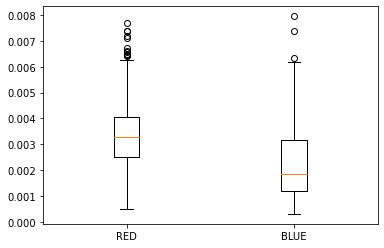

Ttest_indResult(statistic=11.632199864779684, pvalue=5.847206278351935e-30)

In [23]:
# Compare political affiliations
reds = merged_df[merged_df['Party'] == 'REPUBLICAN']['Deaths per Capita']
blues = merged_df[merged_df['Party'] == 'DEMOCRAT']['Deaths per Capita']

plt.boxplot([reds, blues], labels=['RED', 'BLUE'])
plt.show()

stats.ttest_ind(reds, blues)

In [24]:
#Takes axis and col names, r=True puts r-value in legend, by default it doesn't, xunit/yunit add unit to labels
def makescatter(ax, col1, col2, r=False, xunit='', yunit=''):
    xs = merged_df[col1]
    ys = merged_df[col2]
    (m, b, rvalue, p, q) = stats.linregress(xs, ys)
    regress = [m*x + b for x in xs]
    ax.scatter(xs, ys)
    ax.plot(xs, regress, 'r-', label=round(rvalue**2, 3))
    if xunit:
        col1 += f' ({xunit})'
    if yunit:
        col2 += f' ({yunit})'
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.set_title(col1 + ' vs ' + col2)
    if r:
        ax.legend()
    return

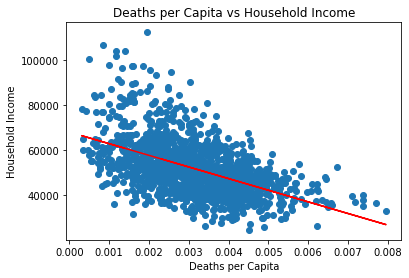

In [25]:
#plotting 1 plot, no extra stuff
fig, ax1 = plt.subplots(1,1)

makescatter(ax1, 'Deaths per Capita', 'Household Income')


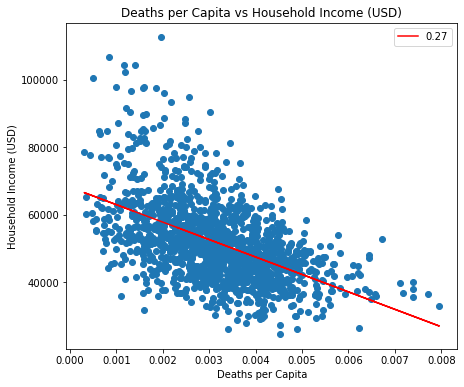

In [26]:
#plotting 1 plot, with rvalue and yunit and figsize corrected
fig, ax1 = plt.subplots(1,1, figsize=(7,6))

makescatter(ax1, 'Deaths per Capita', 'Household Income', r=True, yunit='USD')


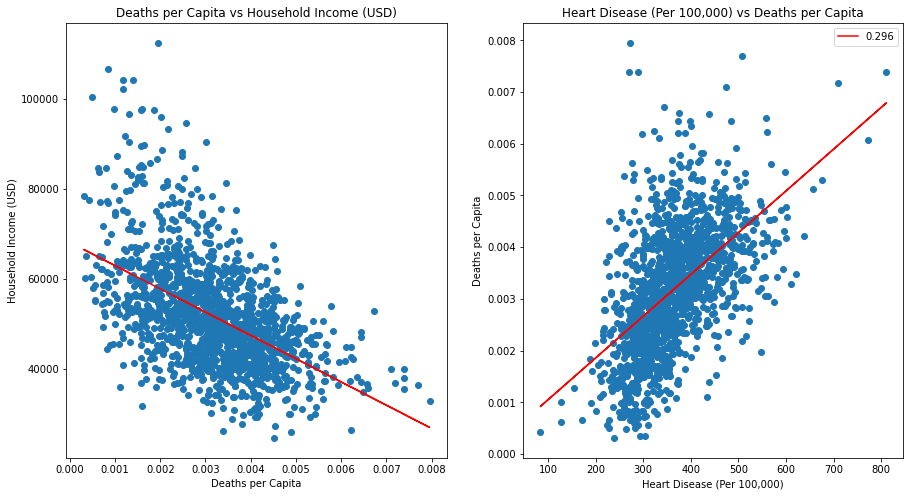

In [27]:
#plotting 2 plots

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))

makescatter(ax1, 'Deaths per Capita', 'Household Income', yunit='USD')

makescatter(ax2, 'Heart Disease', 'Deaths per Capita', xunit='Per 100,000', r=True)


## Boxplots

## Boxplot for Deaths per Capita

In [28]:
#Divide states in 2 by alphabetical order
first_half_states = merged_df[merged_df["State"].str[0] <= "M"] #Select those states whose first letter <= "M"
second_half_states= merged_df[merged_df["State"].str[0] > "M"] #Select those states whose first letter > "M"

In [29]:
def create_vertical_box_plot(figsize,title,df1,df2,column,by,ylabel_1,ylabel_2):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,8))
    
    df1.boxplot(ax = ax1,column = column, by=by, rot = 90); #figsize=(20,10)
    ax1.set_title(ylabel_1, fontsize = 12);

    df2.boxplot(ax = ax2,column =column, by=by, rot = 90);
    ax2.set_title(ylabel_2, fontsize = 12);
    
    fig.tight_layout(pad = 3) #separation between boxplots
    fig.suptitle(title, fontsize = 20, fontweight = "bold")
    return

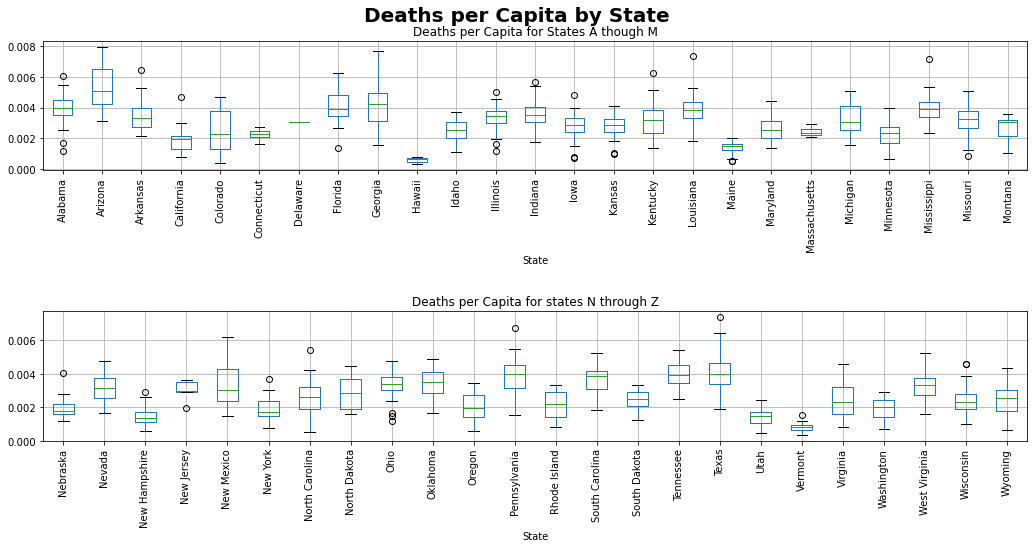

In [30]:
#Create box plot deaths per capita calling function above
create_vertical_box_plot((20,10),"Deaths per Capita by State",first_half_states, second_half_states, "Deaths per Capita","State", "Deaths per Capita for States A though M", "Deaths per Capita for states N through Z")

## Box plot for Cases by Capita

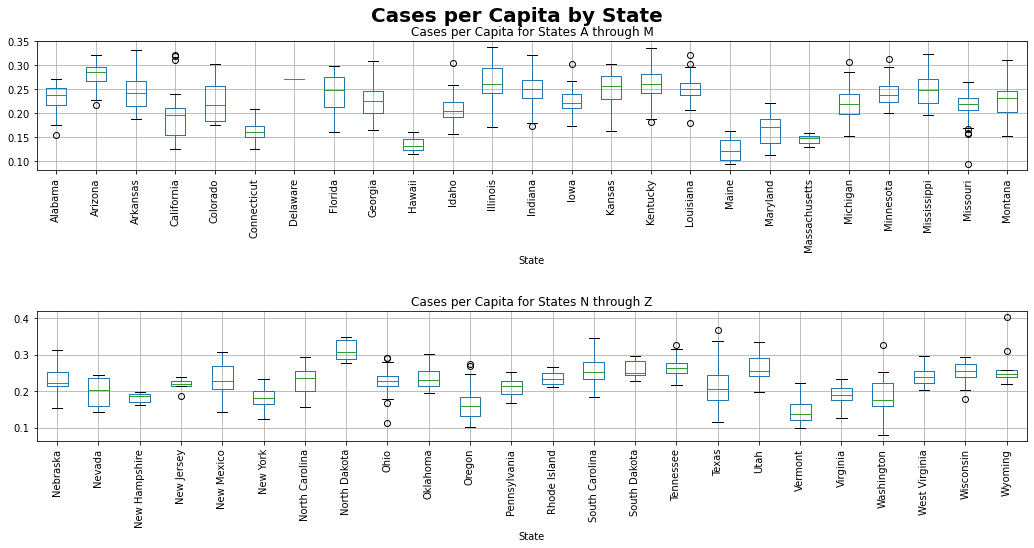

In [31]:
create_vertical_box_plot((20,10),"Cases per Capita by State",first_half_states,second_half_states,"Cases per Capita","State","Cases per Capita for States A through M","Cases per Capita for States N through Z");

## Heat Maps

In [32]:
#import dependencies
import requests
import gmaps
import os

# Import API key
from api_keys import g_key
gmaps.configure(api_key = g_key)

In [33]:
#Select those states with Highest number of Cases per Capita
#Sort Descending by Cases per Capita
sorted_df_by_cases = merged_df.sort_values(by=["Cases per Capita"], ascending=False,ignore_index = True).head(5)

#create locations for heatmap
locations_sorted_df_by_cases = sorted_df_by_cases[["Y_Latitude", "X_Longitude"]]

#shocase the df
sorted_df_by_cases

,Cases,Deaths,Vaccination Rate,Population,Median Age,Household Income,Heart Disease,Y_Latitude,X_Longitude,Stroke,Party,County,State,Cases per Capita,Deaths per Capita
0,9272,15.0,90.3,23059.0,39.3,83831.0,170.5,43.926156,-110.594230,48.2,DEMOCRAT,Teton,Wyoming,0.402099,0.000651
1,9907,121.0,53.1,27009.0,33.9,41752.0,335.4,29.359158,-99.765318,82.6,REPUBLICAN,Uvalde,Texas,0.366804,0.004480
2,10745,80.0,35.7,30876.0,33.9,75708.0,272.5,46.811922,-102.657523,52.9,REPUBLICAN,Stark,North Dakota,0.348005,0.002591
3,42484,535.0,45.5,122746.0,36.2,47024.0,397.3,34.883031,-82.723822,76.0,REPUBLICAN,Pickens,South Carolina,0.346113,0.004359
4,32210,290.0,49.8,93737.0,36.9,69719.0,233.1,46.978215,-100.471199,72.9,REPUBLICAN,Burleigh,North Dakota,0.343621,0.003094


In [34]:
#Select those states with Highest number of Deaths per Capita
#Sort Descending by Cases per Capita
sorted_df_by_deaths = merged_df.sort_values(by=["Deaths per Capita"], ascending=False, ignore_index = True).head(5)

#create locations and info for box templaye for heatmap
locations_sorted_df_by_deaths = sorted_df_by_deaths[["Y_Latitude", "X_Longitude"]]


#shocase the df
sorted_df_by_deaths

,Cases,Deaths,Vaccination Rate,Population,Median Age,Household Income,Heart Disease,Y_Latitude,X_Longitude,Stroke,Party,County,State,Cases per Capita,Deaths per Capita
0,20058,569.0,93.6,71522.0,34.7,32963.0,271.2,35.394866,-109.486870,72.2,DEMOCRAT,Apache,Arizona,0.280445,0.007956
1,7343,202.0,44.5,26216.0,41.7,36529.0,507.9,32.877728,-84.298849,160.9,REPUBLICAN,Upson,Georgia,0.280096,0.007705
2,34605,803.0,72.0,108705.0,36.4,40054.0,270.5,35.401640,-110.314143,73.6,REPUBLICAN,Navajo,Arizona,0.318339,0.007387
3,19171,428.0,86.0,57970.0,29.6,38035.0,289.0,28.741022,-100.315799,73.5,DEMOCRAT,Maverick,Texas,0.330706,0.007383
4,6529,150.0,36.0,20322.0,38.5,35466.0,810.5,32.140156,-91.669639,65.7,REPUBLICAN,Franklin,Louisiana,0.321277,0.007381


In [35]:
# Using the template add the County/State to the heatmap
info_box_template_cases_per_capita = """
<dl>
<dt>County</dt><dd>{County}</dd>
<dt>State</dt><dd>{State}</dd>
<dt>Cases per Capita</dt><dd>{Cases per Capita}</dd>
</dl>
"""

box_template_cases = [info_box_template_cases_per_capita.format(**row) for index, row in sorted_df_by_cases.iterrows()]

In [36]:
# Using the template add the County/State to the heatmap
info_box_template_deaths_per_capita = """
<dl>
<dt>County</dt><dd>{County}</dd>
<dt>State</dt><dd>{State}</dd>
<dt>Deaths per Capita</dt><dd>{Deaths per Capita}</dd>
</dl>
"""

box_template_deaths = [info_box_template_deaths_per_capita.format(**row) for index, row in sorted_df_by_deaths.iterrows()]

In [37]:
def create_map(weights, max_intensity, locations_for_marker_layer, info_box_for_marker_layer, locations_for_symbol_layer, info_box_for_symbol_layer):
    figure = gmaps.figure()
    locations = merged_df[["Y_Latitude", "X_Longitude"]]
    heat_layer = gmaps.heatmap_layer(locations, weights = weights, dissipating = False, max_intensity = max_intensity,point_radius = 0.3)
    figure.add_layer(heat_layer)
    # Add marker layer ontop of heat map
    markers = gmaps.marker_layer(locations_sorted_df_by_cases, info_box_content = info_box_for_marker_layer)
    figure.add_layer(markers)
    symbol_layer = gmaps.symbol_layer(locations_for_symbol_layer, info_box_content=info_box_for_symbol_layer)
    figure.add_layer(symbol_layer)

    return figure

In [38]:
figure1 = create_map(merged_df["Heart Disease"], 600, locations_sorted_df_by_cases, box_template_cases,locations_sorted_df_by_deaths,box_template_deaths)
figure1

Figure(layout=FigureLayout(height='420px'))

In [39]:
figure2 = create_map(merged_df["Stroke"], 0.1, locations_sorted_df_by_cases, info_box_template_cases_per_capita,locations_sorted_df_by_deaths,info_box_template_deaths_per_capita)
figure2

Figure(layout=FigureLayout(height='420px'))

# COVID Cases Per Day

In [40]:
covid_df = pd.read_csv('resources/covid-statistics.csv')
covid_df.head(5)

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [41]:
covid_df["date"] = pd.to_datetime(covid_df["date"])

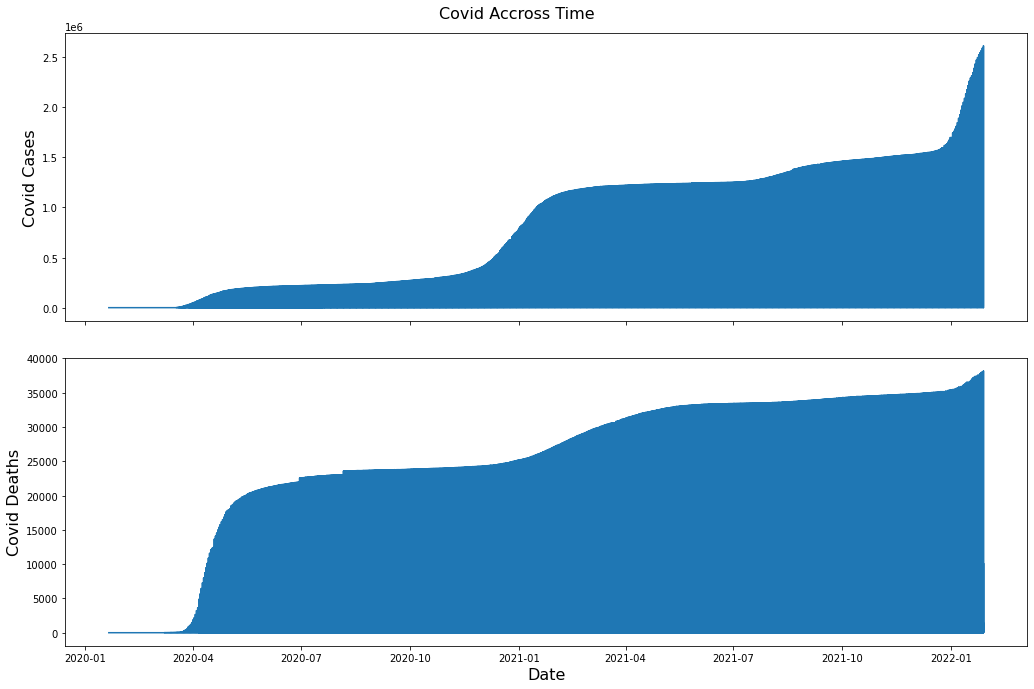

In [42]:
date = covid_df["date"]
covid_cases = covid_df["cases"]
covid_deaths = covid_df["deaths"]

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15, 10),sharex = True) #removed sharey = True

ax1.plot(date, covid_cases)
ax1.set_ylabel("Covid Cases", fontsize = 16)

ax2.plot(date, covid_deaths);
ax2.set_ylabel("Covid Deaths", fontsize = 16)
ax2.set_xlabel("Date", fontsize = 16)

fig.suptitle('Covid Accross Time', fontsize=16)
fig.tight_layout(pad = 3) #separation between boxplots